# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.
Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. <br>  
<br>
<font size=4>**Задача**</font> 

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.  
Также проанализировать возможные прибыль и риски.  

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<font size=4>**Описание данных**</font>  
- id — уникальный идентификатор скважины;  
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
- product — объём запасов в скважине (тыс. баррелей).


<font size=4>**Условия задачи**</font> 
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Зададим темную тему для визуализации графиков
sns.set(style="darkgrid")

In [4]:
# Создадим переменную SEED для использования в качестве random_state параметра
SEED = 12345

## Загрузка и подготовка данных

In [5]:
# Напишем функцию для окрытия и обзора данных
def read_and_print_info(path):
    df = pd.read_csv(path)
    display(df.head(10))
    display(df.info(memory_usage='deep'))
    display(df.describe().T)
    print('Количество дублей:', df.duplicated().sum())
    return df

In [6]:
df_zero = read_and_print_info('/datasets/geo_data_0.csv')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Количество дублей: 0


In [7]:
df_one = read_and_print_info('/datasets/geo_data_1.csv')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Количество дублей: 0


In [8]:
df_two =  read_and_print_info('/datasets/geo_data_2.csv')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Количество дублей: 0


### Удаление данных

В данных можно удалить столбец id, так как эти данные не нужны модели машинного обучения. Нас интересуют регионы, а не конкретные скважины. Но предварительно посмотрим на идентификатор, может есть аномалии. 

Проверим идентификатор на уникальные значения

In [9]:
df_zero['id'].value_counts()
   
    

74z30    2
bsk9y    2
Tdehs    2
HZww2    2
QcMuo    2
        ..
CPjRO    1
mfDyg    1
rHser    1
nG7e7    1
TNDIp    1
Name: id, Length: 99990, dtype: int64

In [10]:
df_one['id'].value_counts()

bfPNe    2
5ltQ6    2
wt4Uk    2
LHZR0    2
D686N    1
        ..
BVYaI    1
mVTxL    1
q68zX    1
zcy4Z    1
vOUC4    1
Name: id, Length: 99996, dtype: int64

In [11]:
df_two['id'].value_counts()

VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
ZdIiI    1
        ..
iKL2O    1
pockI    1
7cswX    1
mjlH2    1
zeHX7    1
Name: id, Length: 99996, dtype: int64

In [12]:
print(df_zero.query('id == "bxg6G"'))
print()
print(df_one.query('id == "bfPNe"'))
print()
print(df_two.query('id == "KUPhW"'))

          id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798

          id        f0        f1        f2     product
2721   bfPNe -9.494442 -5.463692  4.006042  110.992147
82178  bfPNe -6.202799 -4.820045  2.995107   84.038886

          id        f0        f1        f2     product
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
55967  KUPhW  1.211150  3.176408  5.543540  132.831802


В датасетах есть сведения о скважинах с одинаковыми именами, но разными признаками. Таких дублирующихся скважин немного, но они подозрительны. Удалим их, оставив только уникальные. На качество модели удаление такого небольшого количества данных повлиять не должно.

In [13]:
#напишем функцию для удаления наблюдений с дублирующимися id, которая на вход будет принимать название датасета
def remove_double (data):
    names = data['id'].value_counts().reset_index()
    unique_names = names.query('id == 1')['index'].to_list()
    data.query('id in @unique_names', inplace=True)

In [14]:
remove_double(df_zero)
print(df_zero.shape)
remove_double(df_one)
print(df_one.shape)
remove_double(df_two)
print(df_two.shape)

(99980, 5)
(99992, 5)
(99992, 5)


Теперь удалим столбец id, так как эти данные не нужны модели машинного обучения. 

In [15]:
df_zero.drop(['id'], axis=1, inplace=True)
df_one.drop(['id'], axis=1, inplace=True)
df_two.drop(['id'], axis=1, inplace=True)

df_zero = df_zero.reset_index(drop=True)
df_one = df_one.reset_index(drop=True)
df_two = df_two.reset_index(drop=True)

In [16]:
print(df_zero.head())
print()
print(df_one.head())
print()
print(df_two.head())

         f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.365080   73.037750
2  1.022732  0.151990  1.419926   85.265647
3 -0.032172  0.139033  2.978566  168.620776
4  1.988431  0.155413  4.751769  154.036647

          f0         f1        f2     product
0 -15.001348  -8.276000 -0.005876    3.179103
1  14.272088  -3.475083  0.999183   26.953261
2   6.263187  -5.948386  5.001160  134.766305
3 -13.081196 -11.506057  4.999415  137.945408
4  12.702195  -8.147433  5.004363  134.766305

         f0        f1        f2     product
0 -1.146987  0.963328 -0.828965   27.758673
1  0.262778  0.269839 -2.530187   56.069697
2  0.194587  0.289035 -5.586433   62.871910
3  2.236060 -0.553760  0.930038  114.572842
4 -0.515993  1.716266  5.899011  149.600746


### Распределения данных
Посмотрим на распределения данных. Добавим функции:
- две функции строят гистограмму и диаграмму размаха по полученному датафрейму и имени столбца
- ещё одна функция принимает на вход датафрейм и передаёт его первым двум функциям вместе с именами столбцов

In [17]:
def draw_hist(column, subtitle, ax):
    sns.distplot(column, bins=20, color='#66B032', ax=ax)
    ax.set(title=subtitle)

In [18]:
def draw_box(column, subtitle, ax):
    sns.boxplot(y=column, boxprops=dict(facecolor='b', color='#347C98'), medianprops=dict(color='#66B032'), capprops=dict(color='#347C98'), whiskerprops=dict(color='#347C98'), ax=ax)
    ax.set(title=subtitle)

In [19]:
def draw_distribution(df, title):
    for column in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(title)
        draw_hist(df[column], ('Распределение ' + column), axes[0])
        draw_box(df[column], ('Диаграмма размаха ' + column), axes[1])

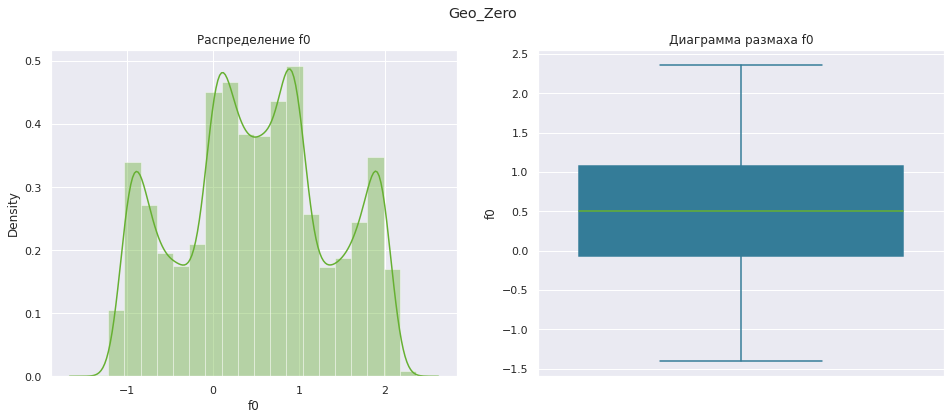

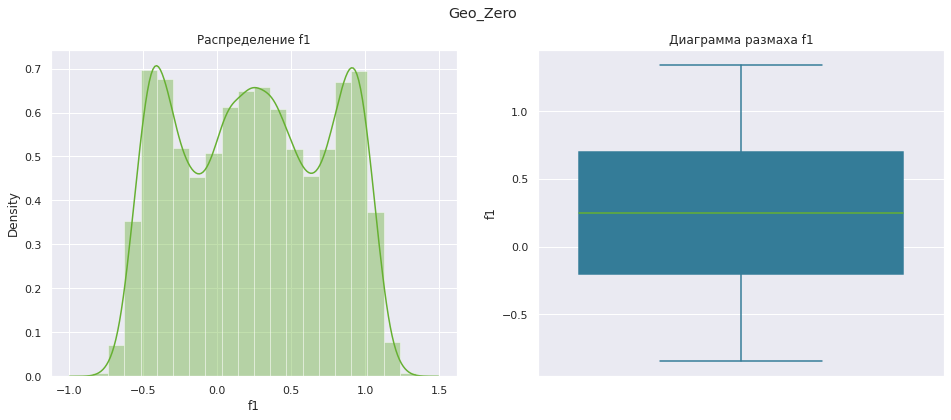

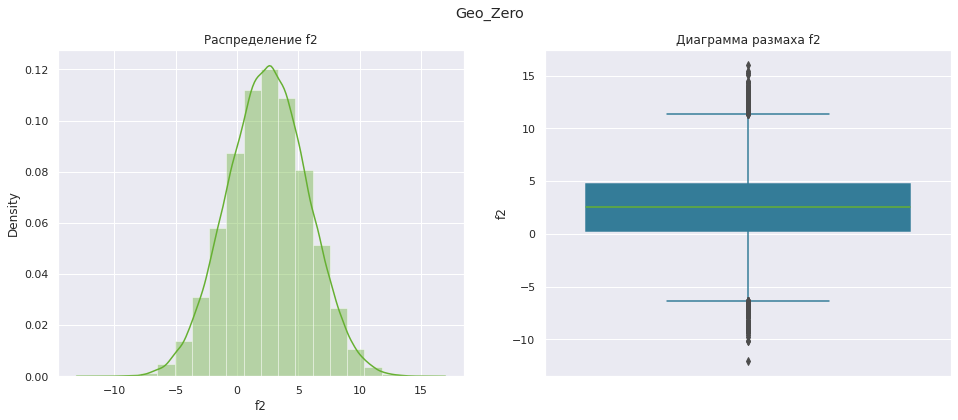

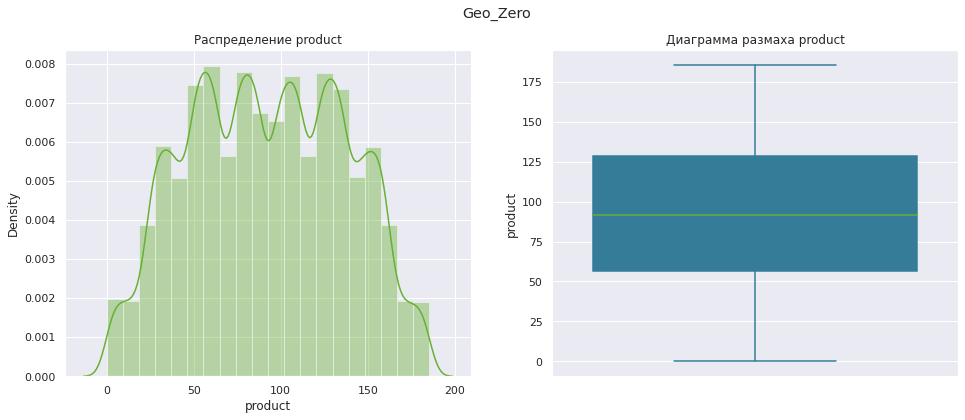

In [20]:
draw_distribution(df_zero, title='Geo_Zero')

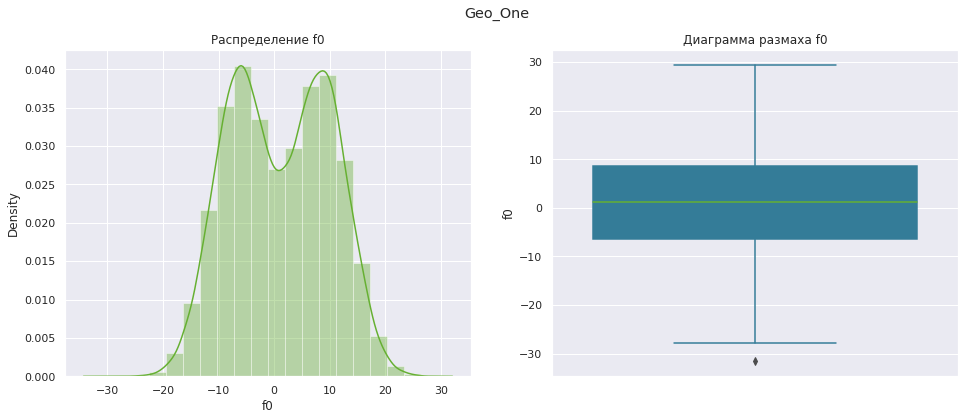

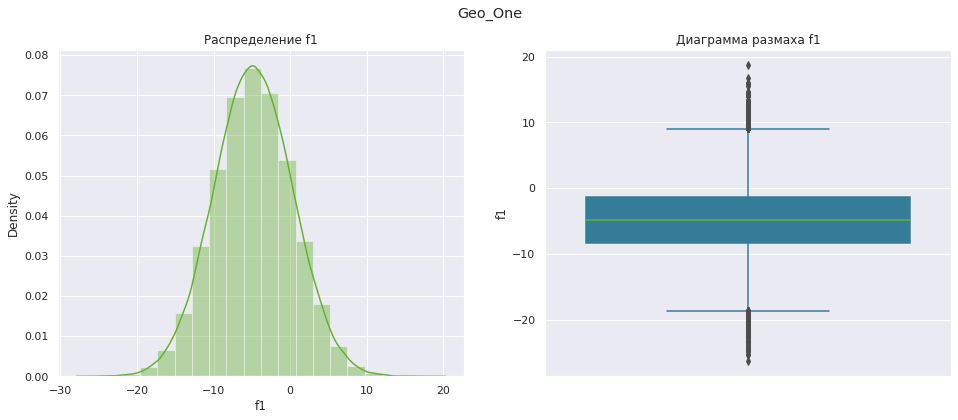

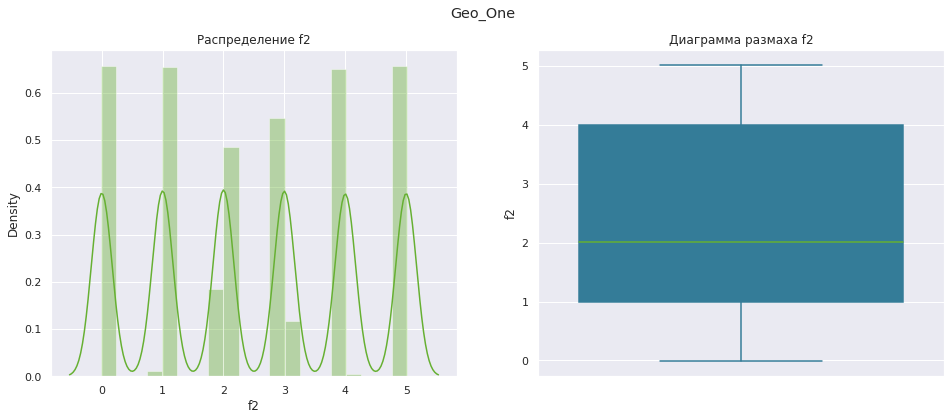

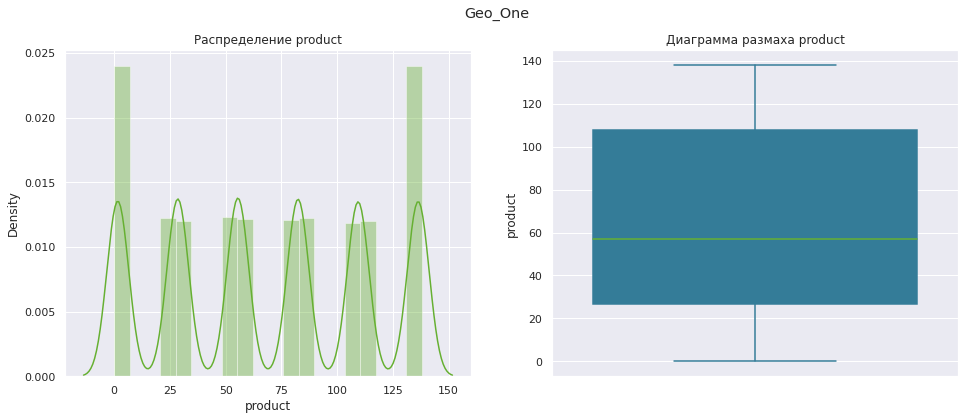

In [21]:
draw_distribution(df_one, title='Geo_One')

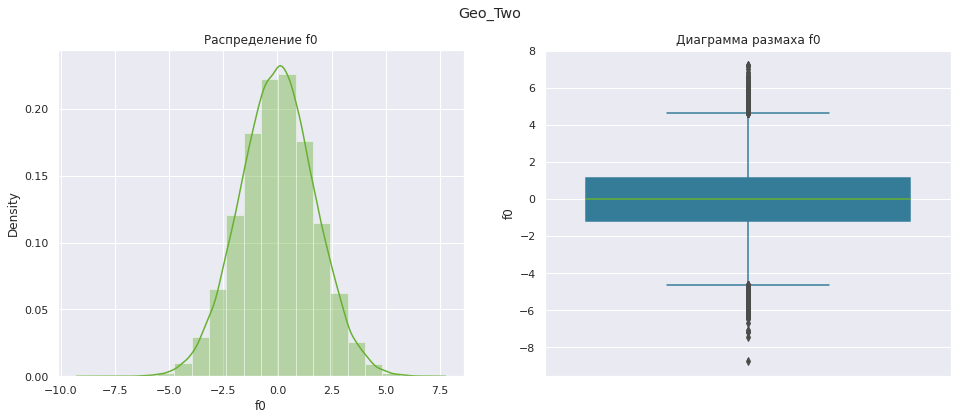

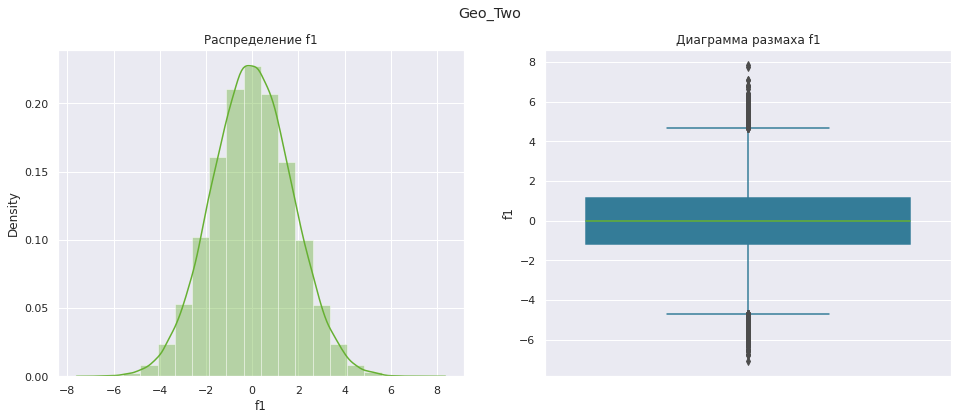

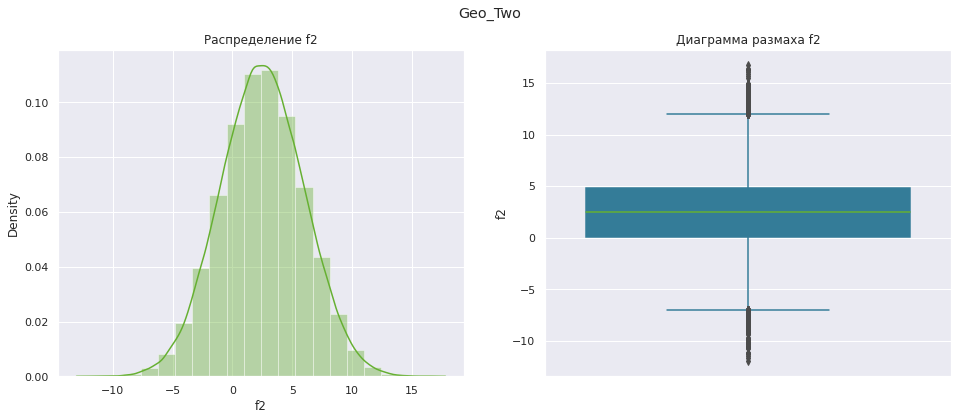

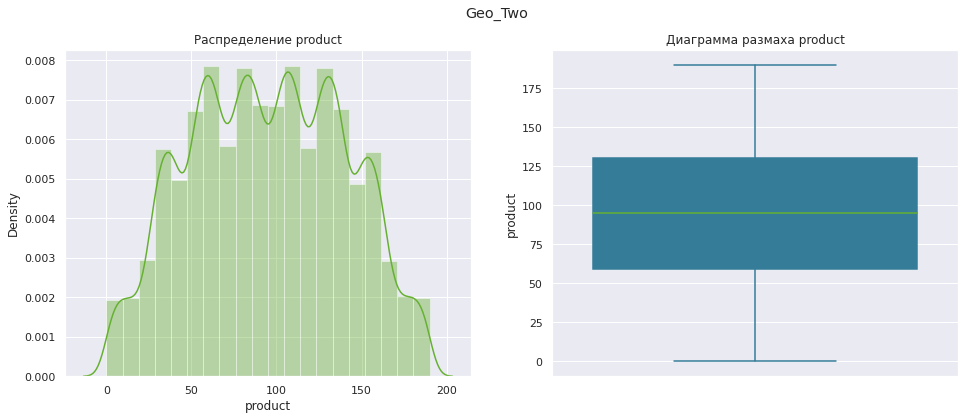

In [22]:
draw_distribution(df_two, title='Geo_Two')

- Распределения некоторых признаков отличаются от нормального. Также присутствуют небольшие выбросы. Так как неизвестно, что означают сами признаки, сложно оценить адекватность распределений и выбросов.
- Масштабы распределений признаков f0, f1, f2 не сильно отличаются друг от друга (меньше одного порядка). Нет необходимости применять масштабирование.
- На данном этапе оставим данные как есть.
- Разделим данные на признаки и целевой признак.

<font size=4>**Вывод**</font>  
Первичный осмотр данных показал:

- в данных нет пропусков
- нет дубликатов
- типы данных подходящие
- масштабы распределений признаков не сильно отличны
- на данном этапе мы оставляем данные в том виде, в котором они нам предоставлены

## Обучение и проверка модели

### Выделение целевого признака
Выделим предикторы и целевой признак

In [23]:
features = ['f0', 'f1', 'f2']
target = ['product']

X_0 = df_zero[features]
y_0 = df_zero[target]
X_1 = df_one[features]
y_1 = df_one[target]
X_2 = df_two[features]
y_2 = df_two[target]

### Разбиение данных, обучение и проверка модели

Добавим функцию, которая выводит процент количества элементов одного датафрейма от другого

In [24]:
def elements_percent(title, first, second):
    print(title, '{:.2%}'.format(first.shape[0]/second.shape[0]))

In [25]:
def model_fit_valid(X, y):
    """
    input: X, y - признаки и целевой признак для модели
    output: y_valid - целевой пизнак валидационной выборки 
            predict - предсказания модели на валидационной выборке
    description: функция разделяет исходные данные на обучающую и валидационную выборки (75/25),
                 обучает модель линейной регрессии, делает предсказания на валидационной выборке,
                 считает и выводит на экран среднее значение предсказаний и RMSE модели.
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    elements_percent('Размер обучающей выборки:', X_train, X)
    elements_percent('Размер валидационной выборки:', X_valid, X)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)

    predict_mean = predict.mean()
    rmse = mean_squared_error(y_valid, predict)**.5

    print('Cредний запас предсказанного сырья: {:.4f}'.format(predict_mean))
    print('RMSE модели: {:.4f}'.format(rmse))
    
    return y_valid, predict

In [26]:
y_valid_0, predicts_0 = model_fit_valid(X_0, y_0)

Размер обучающей выборки: 75.00%
Размер валидационной выборки: 25.00%
Cредний запас предсказанного сырья: 92.2865
RMSE модели: 37.7611


In [27]:
y_valid_1, predicts_1 = model_fit_valid(X_1, y_1)

Размер обучающей выборки: 75.00%
Размер валидационной выборки: 25.00%
Cредний запас предсказанного сырья: 69.1689
RMSE модели: 0.8929


In [28]:
y_valid_2, predicts_2 =  model_fit_valid(X_2, y_2)

Размер обучающей выборки: 75.00%
Размер валидационной выборки: 25.00%
Cредний запас предсказанного сырья: 94.8207
RMSE модели: 40.1312


<font size=4>**Вывод**</font>     

- В регионах Zero и Two достаточно большой показатель среднего предсказанного запаса сырья (92.2865 и 94.8207), но у этих регионов достаточно высокая RMSE (37.76 и 40.13), что говорит о том, что модель неоднозначна и не отличается высокой точностью.
- В регионе One средний предсказанный запас сырья меньше - 69.1689, но RMSE равен 0.89. Можем сделать вывод, что эта модель точнее.

## Подготовка к расчёту прибыли

- Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.
- Сравним полученный объём сырья со средним запасом в каждом регионе.  


- **min_product = budget / (top_wells * unit_income)**
 - budget - Бюджет на разработку скважин в регионе — 10 млрд рублей
 - top_wells, samp_wells - При расчёте выбирают 200 лучших скважин из 500 в выборке
 - unit_income - Доход с каждой единицы продукта составляет 450 тыс. рублей

In [29]:
BUDGET = 10**10
TOP_WELLS = 200
SAMP_WELLS = 500
UNIT_INCOME = 4.5*10**5

In [30]:
min_product = BUDGET / (TOP_WELLS * UNIT_INCOME)
print('Минимальный объём продукта с одной скважины для безубыточной разработки: {:.2f}'.format(min_product))

Минимальный объём продукта с одной скважины для безубыточной разработки: 111.11


<font size=4>**Вывод**</font>

- Минимальный объём продукта для безубыточной разработки составляет 111.11. 
- Данный показатель рассчитан при условии выбора 200 лучших скважин из 500 в выборке.
- Данное значение превышает средние значения запасов скважин по всем регионам.

## Расчёт прибыли и рисков 

In [31]:
valid_y_0 = pd.Series(y_valid_0['product']).reset_index(drop=True)
valid_y_1 = pd.Series(y_valid_1['product']).reset_index(drop=True)
valid_y_2 = pd.Series(y_valid_2['product']).reset_index(drop=True)

predicts_y_0 = pd.Series(predicts_0[:, 0])
predicts_y_1 = pd.Series(predicts_1[:, 0])
predicts_y_2 = pd.Series(predicts_2[:, 0])

### Расчёт прибыли
Напишем функцию для расчёта прибыли:

выберем случайно 500 точек и отберём 200 с максимальным показателем объёма сырья
просуммируем целевое значение объёма сырья
рассчитаем прибыль

In [32]:
#def income_predict(y_target, y_predict, state, title='', need_to_print=False):
def profit_predict(y_target, y_predict, state, title='', need_to_print=False):
    sample = y_predict.sample(n=SAMP_WELLS, replace=True, random_state=state)
    top_predictions = sample.sort_values(ascending=False).head(TOP_WELLS)
    top_targets = y_target[top_predictions.index]
    top_mean = top_targets.mean()
    top_sum = top_targets.sum()
    #top_income = top_sum * UNIT_INCOME - BUDGET
    top_profit = top_sum * UNIT_INCOME - BUDGET
    if need_to_print:
        print('-----', title, '-----')
        print('Средний запас сырья: {:.2f}'.format(top_mean))
        print('Суммарный объём сырья: {:.1f}'.format(top_sum))
        print('Прибыль для полученного суммарного объёма сырья: {:.0f}'.format(top_profit))
    return top_profit

In [33]:
income_0 = profit_predict(valid_y_0, predicts_y_0, SEED, title='Регион "Zero"', need_to_print=True)

----- Регион "Zero" -----
Средний запас сырья: 117.30
Суммарный объём сырья: 23460.7
Прибыль для полученного суммарного объёма сырья: 557304911


In [34]:
income_1 = profit_predict(valid_y_1, predicts_y_1, SEED, title='Регион "One"', need_to_print=True)

----- Регион "One" -----
Средний запас сырья: 116.08
Суммарный объём сырья: 23215.6
Прибыль для полученного суммарного объёма сырья: 447021776


In [35]:
income_2 = profit_predict(valid_y_2, predicts_y_2, SEED, title='Регион "Two"', need_to_print=True)

----- Регион "Two" -----
Средний запас сырья: 116.38
Суммарный объём сырья: 23276.5
Прибыль для полученного суммарного объёма сырья: 474445907


### Расчёт рисков
Добавим некоторые переменные для техники Bootstrap  
- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [36]:
samples_count = 1000
alpha = .05

In [37]:
def risk_calc(title, y_target, y_predict):
    #incomes = []
    profits = []
    loss_count = 0
    state = np.random.RandomState(SEED)
    for i in range(samples_count):
        profit = profit_predict(y_target, y_predict, state)
        profits.append(profit)
        if profit < 0:
            loss_count += 1
    profits = pd.Series(profits)
    profits_mean = profits.mean()
    lower = profits.quantile(alpha / 2)
    upper = profits.quantile(1 - alpha / 2)
    #loss_rate = loss_count / samples_count
    
    print('-----', title, '-----')
    print('Количество повторений Bootstrap техники:', samples_count)
    print('Средняя прибыль: {:.2f}'.format(profits_mean))
    print('Нижняя граница доверительного интервала: {:.2f}'.format(lower))
    print('Верхняя граница доверительного интервала: {:.2f}'.format(upper))
    #print('Риск убытков: {:.2%}'.format(loss_rate))
    print('Риск убытков:', (profits < 0).mean())

In [38]:
risk_calc('Регион "Zero"', valid_y_0, predicts_y_0)

----- Регион "Zero" -----
Количество повторений Bootstrap техники: 1000
Средняя прибыль: 396713209.98
Нижняя граница доверительного интервала: -101791405.46
Верхняя граница доверительного интервала: 931564037.52
Риск убытков: 0.072


In [39]:
risk_calc('Регион "One"', valid_y_1, predicts_y_1)

----- Регион "One" -----
Количество повторений Bootstrap техники: 1000
Средняя прибыль: 488472615.60
Нижняя граница доверительного интервала: 90888856.31
Верхняя граница доверительного интервала: 894380080.96
Риск убытков: 0.01


In [40]:
risk_calc('Регион "Two"', valid_y_2, predicts_y_2)

----- Регион "Two" -----
Количество повторений Bootstrap техники: 1000
Средняя прибыль: 357474160.79
Нижняя граница доверительного интервала: -120489907.85
Верхняя граница доверительного интервала: 897140764.49
Риск убытков: 0.073


<font size=4>**Выводы**</font>  

При расчёте показателей для 200 наилучших скважин из 500 в выборке:
- Средний запас сырья с одной скважины среди всех регионов (117, 116, 116 соответственно) превосходит минимально необходимый объём 111.11.  

При применении техники bootstrap:  
- Оценка средней прибыли максимальна для региона 1 (488 млн.).
- Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу.
- Риск убытков для региона 1 (1.0%)  

Рекомендуем регион 1 для разработки.


## Общий Вывод  


При начальном построении модели и предсказаний:  

В регионах 0 и 2 достаточно высокий средний показатель запаса предсказанного сырья. Однако RMSE для данных регионов также высок (37.76 и 40.13 соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.  

В регионе 1 средний показатель запаса предсказанного сырья составляет 69.2 (ниже остальных регионов). Однако RMSE в данном регионе также мал (0.9). Это говорит о точности предсказаний и качестве построенной модели.  

Средние показатели предсказанного сырья для одной скважины ниже теоретически необходимых (111.11)

***При расчёте показателей для 200 наилучших скважин из выборочных 500:***
- Средний запас сырья с одной скважины среди всех регионов превосходит минимально необходимый объём.  


При применении техники bootstrap:
- Оценка средней прибыли максимальна для региона 1 (488 млн.).
- Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу.
- Риск убытков для региона 1 (1.0%)
- Рекомендуем регион 1 для разработки.